# Projeto Final  - INF-0612 

Paulo Roberto de Almeida Costa

# Horário de Verão

Os horários estão formatados no fuso horário local, o que é muito prático para humanos, mas possivelmente problemático para máquinas.

Por exemplo, existem descontinuidades quando o horário de verão começa ou termina. Em particular, o intervalo 23:00-23:59 ocorre 2 vezes no último dia de horário de verão, e é sempre problemático.

Vamos analisar esses momentos de mudança:

In [25]:
time_window <- function(dataframe, from, to) {
    dataframe[
        dataframe$Time >= strptime(from, "%d/%m/%Y-%H:%M", tz = 'America/Sao_Paulo') & dataframe$Time <= strptime(to, "%d/%m/%Y-%H:%M", tz = 'America/Sao_Paulo'), 
    ]
}

#time_window(cepagri, "21/02/2015-22:50", "22/02/2015-00:10")
time_window(cepagri, "17/10/2015-23:50", "18/10/2015-02:10")
time_window(cepagri, "20/02/2016-22:50", "21/02/2016-00:10")
#time_window(cepagri, "15/10/2016-23:50", "16/10/2016-02:10")
#time_window(cepagri, "18/02/2017-22:50", "19/02/2017-00:10")
#time_window(cepagri, "20/10/2017-23:50", "21/10/2017-02:10")

,Time,Temperature,Wind,Humidity,Apparent.Temperature
83380,2015-10-17 23:50:00,18.8,86.6,70.3,17.4
83381,2015-10-18 01:00:00,18.7,87.7,70.5,17.3
83382,2015-10-18 01:10:00,NA,NA,NA,NA
83383,2015-10-18 01:20:00,NA,NA,NA,NA
83384,2015-10-18 01:30:00,NA,NA,NA,NA
83385,2015-10-18 01:40:00,NA,NA,NA,NA
83386,2015-10-18 01:50:00,NA,NA,NA,NA
83387,2015-10-18 02:00:00,NA,NA,NA,NA
83388,2015-10-18 02:10:00,NA,NA,NA,NA


,Time,Temperature,Wind,Humidity,Apparent.Temperature
101073,2016-02-20 22:50:00,25.1,7.8,81.7,24.0
101074,2016-02-20 23:00:00,25.1,7.8,81.7,24.0
101075,2016-02-20 23:10:00,23.6,20.3,90.2,22.5
101076,2016-02-20 23:20:00,23.0,28.8,92.1,21.9
101077,2016-02-20 23:30:00,22.5,25.9,93.5,21.4
101078,2016-02-20 23:40:00,22.4,27.1,96.0,21.3
101079,2016-02-20 23:50:00,21.8,26.4,96.5,20.7
101080,2016-02-20 23:00:00,21.4,24.7,96.0,20.3
101081,2016-02-20 23:10:00,NA,NA,NA,NA
101082,2016-02-20 23:20:00,NA,NA,NA,NA


Nas tabelas acima, podemos ver que ocorrem erros quando o horário de verão começa ou termina. __O problema se repete todos os anos!__ (As tabelas foram omitido para redução de espaço)

É consenso que trabalhar com fuso-horários é dificil e complica ainda mais quando entra o horário de verão, mas estou assustado que causem problemas tão consistentemente neste dataset.

Quanto ao intervalo ambiguo das 23:00 a 23:59 que ocorre no último dia do horário de verão, podemos resolver a ambiguidade adicionando 1h sempre que uma linha do dataframe "volta no tempo" em comparação à linha anterior.

# Limpeza dos dados

O horário de verão foi uma análise interessante e,uma vez que causa tantos erros, precisava ser feito antes da limpeza dos dados.

Daqui para frente, poderemos ignorar linhas com erro e remover duplicadas (Ficando apenas com a primeira ocorrencia)

# Distribuição de dados

Como primeira análise dos dados propriamente ditos, vamos visualizar as distribuições de cada variável, e procurar por problemas com outliers.

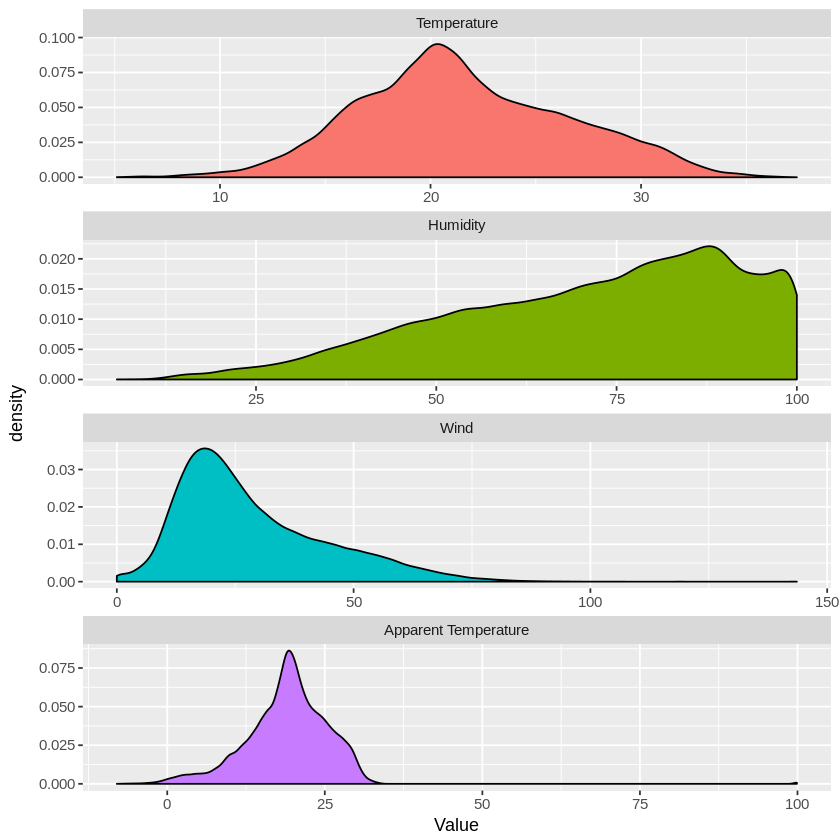

In [6]:
field_values <- rbind(
    data.frame(Attribute = 'Temperature',          Value = cepagri$Temperature),
    data.frame(Attribute = 'Humidity',             Value = cepagri$Humidity),
    data.frame(Attribute = 'Wind',                 Value = cepagri$Wind),
    data.frame(Attribute = 'Apparent Temperature', Value = cepagri$Apparent.Temperature)
)

p <- ggplot(field_values, aes(x = Value, fill = Attribute))
p <- p + facet_wrap(~ Attribute, scales = "free", ncol=1)
p <- p + geom_density()
p <- p + theme(legend.position="none")
p


Tanto a _temperatura_ quanto a _umidade_ parecem bem comportadas e dentro dos intervalos esperados, mas o _vento_ e a _sensação térmica_  possuem outliers muito grandes que merecem investigação.

## Outliers de Sensação Térmica

Vamos ver uma amostra dos dias em que a _Sensação Térmica_ ultrapassou 40ºC

In [7]:
apparent.temperature.outliers <- cepagri[cepagri$Apparent.Temperature > 40, ]

# Show some of the outliers (Sampled 1 out of every 5 outliers for brevity)
apparent.temperature.outliers[seq(1, nrow(apparent.temperature.outliers), 5), ]

,Time,Temperature,Wind,Humidity,Apparent.Temperature
114706,2016-05-26 07:10:00,13.8,16.9,94.5,99.9
115426,2016-05-31 07:10:00,15.7,15.5,100.0,99.9
116136,2016-06-05 07:10:00,18.5,13.8,100.0,99.9
116856,2016-06-10 07:10:00,6.4,11.7,97.6,99.9
117576,2016-06-15 07:10:00,9.9,16.3,91.9,99.9
118296,2016-06-20 07:10:00,12.2,38.4,98.4,99.9
119016,2016-06-25 07:10:00,12.6,51.9,94.0,99.9
119736,2016-06-30 07:10:00,14.2,27.5,82.4,99.9
120456,2016-07-05 07:10:00,13.6,6.4,82.6,99.9
121175,2016-07-10 07:10:00,12.9,21.9,77.2,99.9


Todos os outliers tem valor 99.9ºC e ocorram exatamente às 7:10, todos os dias entre Maio e Outubro de 2016. Achei esse problema hilário 😂

Não posso deixar de imaginar se isso foi um error real (Cuja causa deve ser muito interessante...), ou uma pegadinha adicionada pelo professor para ser encontrada pelos alunos.

Parece que o único campo afetado por este problema é a _Sensação Térmica_, e ele provavelmente poderia ser obtido através de uma fórmula usando os outros campos. Mas, por segurança e preguiça, vou simplesmente ignorar estas linhas nas análises seguintes.

## Outliers de Vento

Vamos inspecionar os momentos em que o vento ultrapassou 100km/h, usando uma janela de +/- 2 horas.

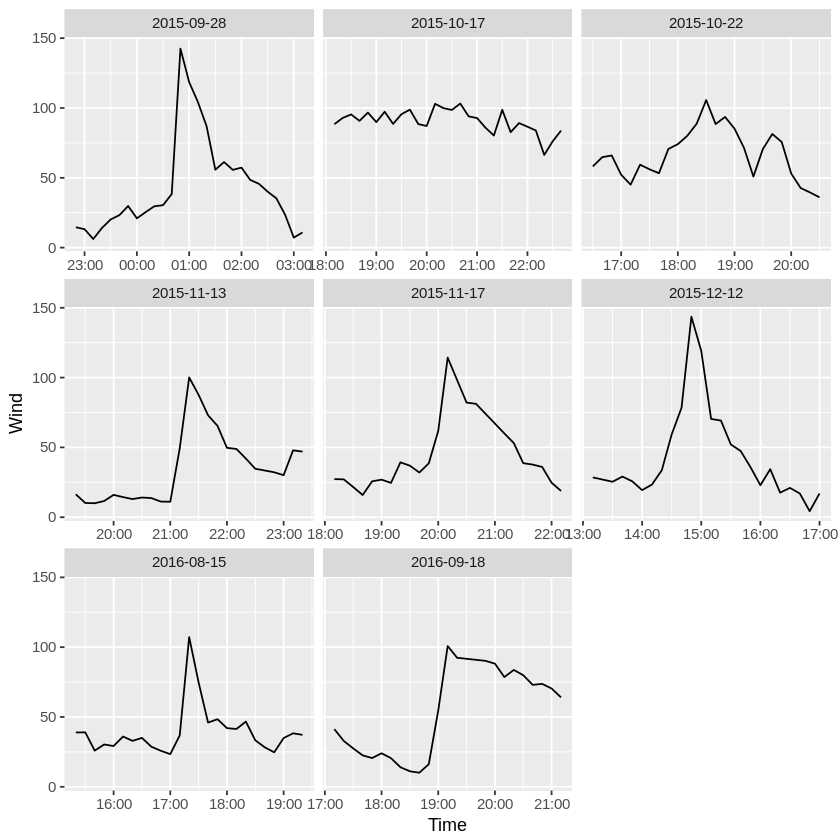

In [9]:
wind.outliers <- cepagri[cepagri$Wind > 100, ]
wind.outliers.window <- 7200  # 2 hours
wind.outliers.date_ranges <- data.frame(min=wind.outliers$Time - wind.outliers.window, max=wind.outliers$Time + wind.outliers.window)
wind.outliers.expanded <- cepagri[sapply(as.POSIXct(cepagri$Time), function(x) {any(x >= wind.outliers.date_ranges$min & x <= wind.outliers.date_ranges$max)}), ]
wind.outliers.expanded$group <- NA

# Split each high-wind day into a separate group
wind.outliers.expanded$Group[1] <- 1
for (i in 2:nrow(wind.outliers.expanded)) {
    if (wind.outliers.expanded$Time[i] > 2*wind.outliers.window + wind.outliers.expanded$Time[i - 1]) {
        wind.outliers.expanded$Group[i] <- wind.outliers.expanded$Group[i-1] + 1
    } else {
        wind.outliers.expanded$Group[i] <- wind.outliers.expanded$Group[i-1]
    }
}

wind.outliers.group.time <- aggregate(as.POSIXct(wind.outliers.expanded$Time), list(Group = wind.outliers.expanded$Group), median)$x
wind.outliers.expanded$GroupTime <- wind.outliers.group.time[ wind.outliers.expanded$Group ]

p <- ggplot(wind.outliers.expanded, aes(y = Wind, x = Time, fill = as.factor(Group)))
p <- p + facet_wrap( ~ strftime(GroupTime, "%Y-%m-%d"), scales = "free_x")
p <- p + geom_line()
p <- p + theme(legend.position="none")
p

Estes gráficos parecem normais, e eu acredito que estes foram simplesmente momentos de __muito__ vento, sem qualquer problema na coleta dos dados.

Mas devo admitir que fiquei surpreso ao não encontrar a Microexplosão que ocorreu em 05/06/2016 nesta lista, a qual teve ventos fortíssimos de até 120km/h, capazes de destruir meu bairro e várias outras partes da cidade.

Vamos verificar:

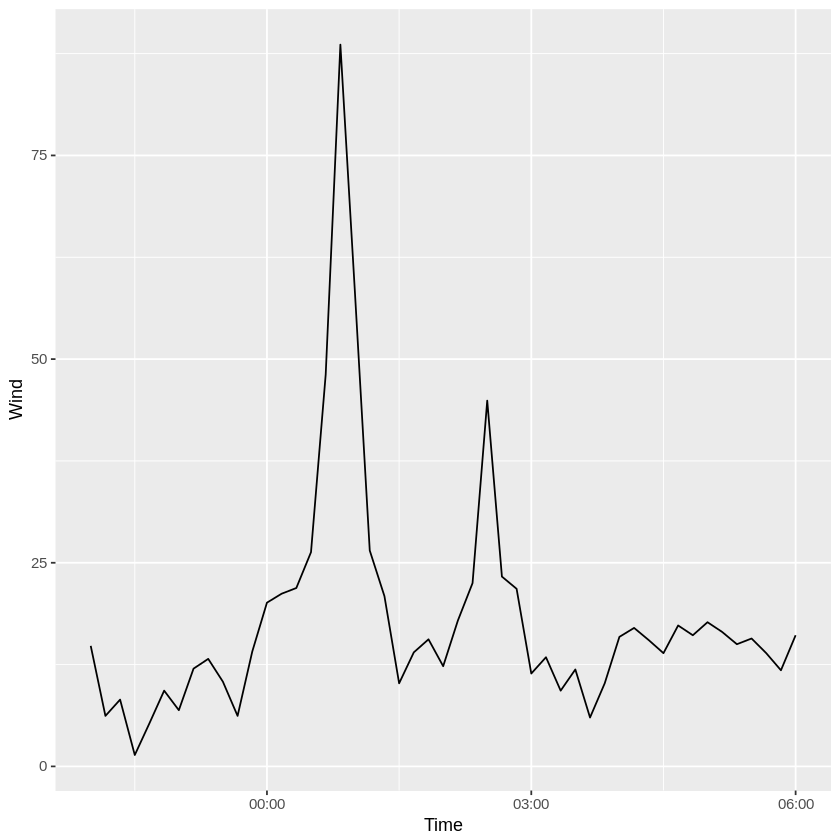

In [10]:
cepagri.microexplosion <- time_window(cepagri, "04/06/2016-22:00", "05/06/2016-6:00")

p <- ggplot(cepagri.microexplosion, aes(y = Wind, x = Time))
p <- p + geom_line()
p <- p + theme(legend.position="none")
p

De acordo com os dados do Cepagri, houve sim muito vento nesta data (88km/h), mas não o suficiente para atingir o limite de 100km/h definido (arbitrariamente) na análise anterior.

Acredito que isso deva ter ocorrido porque a medição do Cepagri não foi realizada no centro da tempestade. (Onde ela é feita? No próprio prédio do Cepagri?)

# Correlações

Vamos visualizar como a Temperatura, Vento, Umidade e Sensação Térmica se correlacionam.

,Temperature,Apparent.Temperature,Wind,Humidity
Temperature,1.0000000,0.9031287,-0.164425429,-0.623340798
Apparent.Temperature,0.9031287,1.0000000,-0.267358278,-0.464479529
Wind,-0.1644254,-0.2673583,1.000000000,0.003857735
Humidity,-0.6233408,-0.4644795,0.003857735,1.000000000


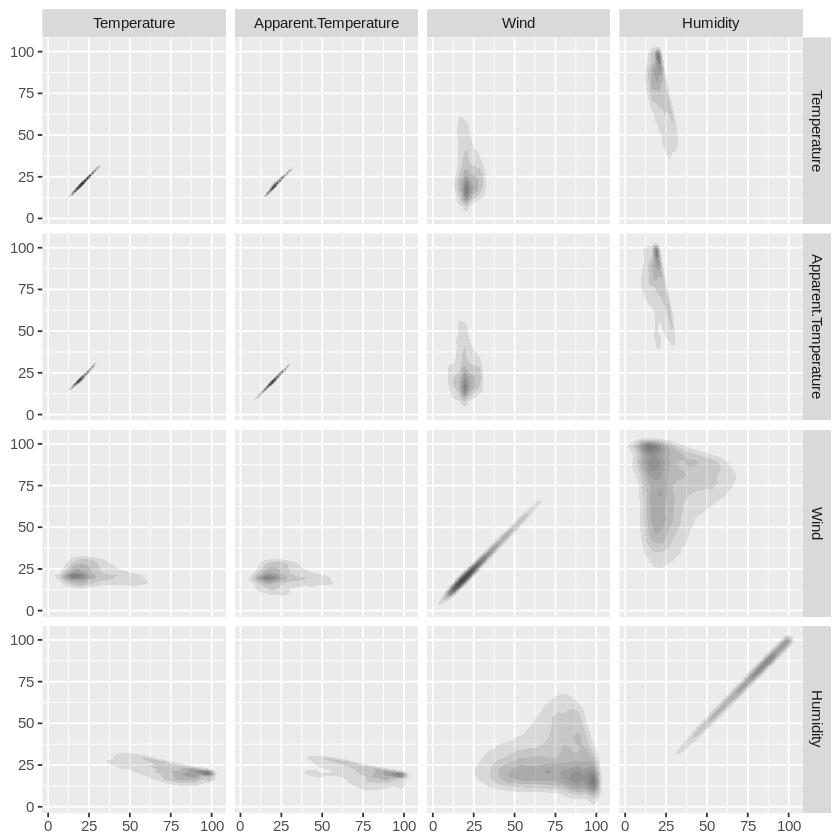

In [11]:
correlation.attributes <- c('Temperature', 'Apparent.Temperature', 'Wind', 'Humidity')

correlation.matrix <- matrix(ncol=length(correlation.attributes), nrow=length(correlation.attributes), dimnames=list(correlation.attributes, correlation.attributes))
for (i in 1:length(correlation.attributes)) {
    for (j in 1:length(correlation.attributes)) {
        correlation.matrix[i,j] <- cor(cepagri[[correlation.attributes[i]]], cepagri[[correlation.attributes[j]]])
    }
}
correlation.matrix

density.grid <- data.frame(var1=c(), value1=c(), var2=c(), value2=c())
for (var1 in correlation.attributes) {
    for (var2 in correlation.attributes) {
        df <- data.frame(var1=var1, value1=cepagri[[var1]], var2=var2, value2=cepagri[[var2]])
        density.grid <- rbind(density.grid, df)
    }
}

p <- ggplot(data=density.grid, aes(x=value1, y=value2))
p <- p + facet_grid(var1 ~ var2)
p <- p + stat_density2d(aes(alpha=..level..), geom="polygon")
p <- p + theme(legend.position="none",  axis.title = element_blank())
p

Exceto pela diagonal principal, esses dados não mostram _linhas_ ou mesmo _elipses_ bonitinhas como as que eu gostaria de ter encontrado, um sinal de que modelar o clima é um problema complicado e que requer modelos bem mais complexos do correlações simples.

Mas apesar disso, podemos notar que:
- Obviamente, _Temperatura_ e _Sensação Térmica_ são altamente correlacionados. Eu não faço idéia de como se calcula a sensação térmica, mas um número muito próximo de 1 já era esperado.
- _Temperatura_ e _Vento_ possuem uma pequena correlação negativa. Acredito que o vento ajude a dispersar o calor.
- _Sensação Térmica_ também possui uma correlação negativa com _Vento_, mas muito mais significativa do que a da _Temperatura_. Neste caso, acredito que o vento possui 2 efeitos aditivos: Ele baixa tanto a _Temperatura_ real quanto a _Sensação Térmica_ para uma dada temperatura.
- _Umidade_ e _Temperatura_ possuem uma correlação negativa muito alta. Acredito que isso seja explicado porque a umidade é mais alta em dias nublados e chuvosas, nos quais as nuvens bloqueiam o sol (Diminuindo a temperatura) e a chuva absorve calor do ar e do chão ao cair.
- Interessante, o efeito da _Umidade_ na _Sensação Térmica_ é menos acentuado do que na _Temperatura_. Acredito que o aumento da umidade aumente a _Sensação Térmica_ (pois diminui a capacidade do corpo de resfriar por transpiração), mas que este efeito não seja suficiente para compensar a influencia da _Umidade_ na _Temperatura_ real.
- Vento e Umidade não possuem correlação significativa. Isso me surpreendeu, uma vez que ambos parecem estar associados a dias de tempestades.

É claro que as explicações dados acima são apenas palpites. As análises foram superficiais, eu não possuo conhecimentos suficientes no assunto e, é claro, correlação não implica causalidade.

![XKCD 552 - Correlation](https://imgs.xkcd.com/comics/correlation.png)

# Tendencias sazonais e por horário

Vamos acompanhar como a _Temperatura_, _Umidade_ e _Vento_ variam em função das estações do ano e hora do dia.

## Tendencias sazonais

Vamos acompanhar como a _Temperatura_, _Umidade_ e _Vento_ variam em função das estações do ano, em anos diferentes.

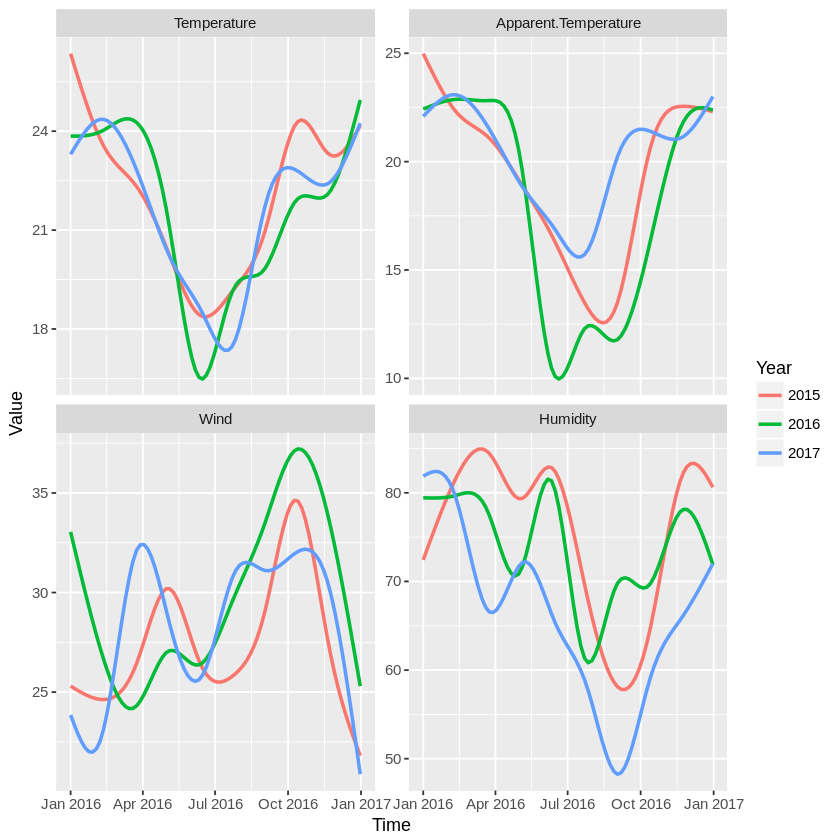

In [17]:
p <- ggplot(data=cepagri.facet, aes(x = Time, y = Value, color = Year, fill = Year, group = Year))
p <- p + facet_wrap(~ Attribute, ncol=2, scales = "free_y")
p <- p + geom_smooth(se = F, method = 'gam', formula = y ~ s(x, bs = "cs"))
p

Através destes gráficos, podemos observar que as medições variam bastante durante o ano, mas possuem uma tendencia clara que é consistente entre anos diferentes.

Como esperávamos, a _Temperatura_ e _Sensação Térmica_ são bem mais altas nos primeiros e últimos meses do ano devido ao verão, e mais baixa nos meses do meio, devido ao inverno.

Outra medida que não surpreendeu foi a umidade, caindo consideravelmente a partir da metade do ano, quando começa nossa época de estiagem.

Quanto ao vento, seu padrão de comportamente sazonal não está tão claro quanto os demais parâmetros, mas parece  que outubro é a melhor época para empinar pipas, seguido de maio ;)

## Tendencias de horário

Vamos comparar também como a hora do dia influencia as diferentes medidas.

(Para evitar problemas com o horário de verão, os horários estão sempre em UTC-3)

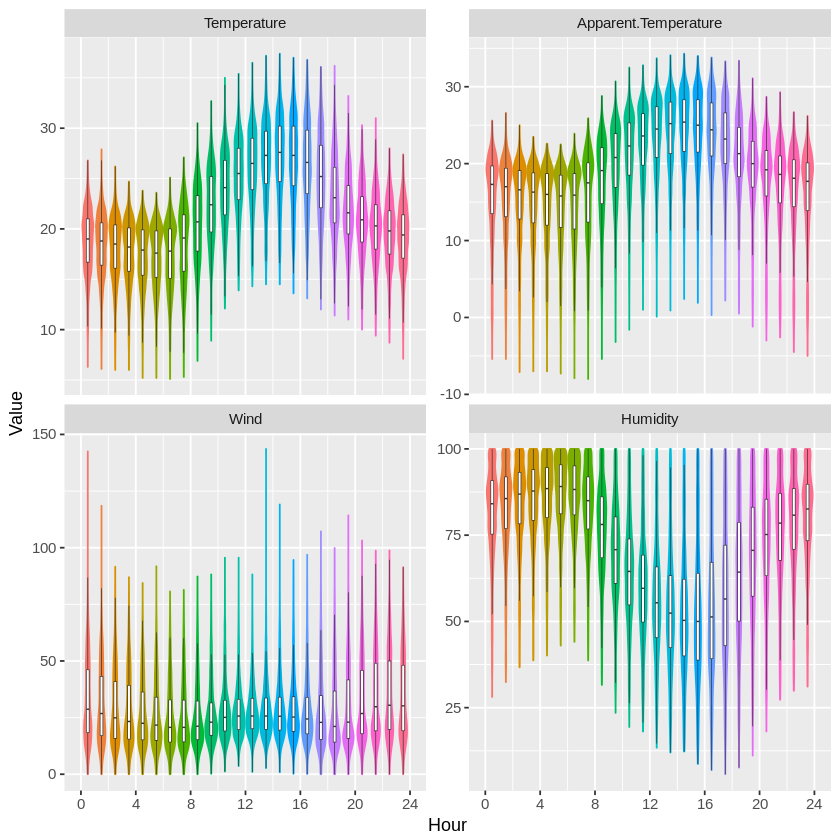

In [13]:
p <- ggplot(data=cepagri.facet, aes(x = as.numeric(Hour)-0.5, y = Value, group = Hour))
p <- p + facet_wrap(~ Attribute, ncol = 2, scales = "free_y")
p <- p + geom_violin(aes(x = as.numeric(Hour)-0.5, color = Hour, fill = Hour))
p <- p + geom_boxplot(width=0.2, outlier.shape = NA, lwd=0.2)
p <- p + theme(legend.position="none")
p <- p + labs(x = "Hour")
p <- p + scale_x_continuous(breaks=seq(0, 24, 4), limits=c(0,24))
p

Neste gráfico, podemos ver claramente que a temperatura (Tanto real quanto a sensação térmica) começa a subir logo após o nascer do sol, cerca de 6h, atinge o máximo aproximadamente às 14h, e volta a cair rapidamente no fim da tarde e mais lentamente durante a madrugada, chegando ao mínimo por volta das 5h.

A Umidade é influenciada de forma oposta: Começa a cair ao nascer do sol e continua caindo até as 15h, quando atinge seu minimo e começa a aumentar novamente. Note que este compartamento é consistente com a correlação negativa que obtivemos antes entre temperatura e umidade, mas não apoia a hipótese de causa criada naquele momento.

Quanto ao vento, o horário parece ter uma influência muito menor nele do que nos outros parâmetros. Apesar da influência relativamente pequena, fica claro que venta mais na parte da noite, especialmente por volta das 22h.

## Tendencias sazonais e por horário simultaneamente

Podemos também visualizar a influência da Sazonalidade e do Horário simultaneamente.

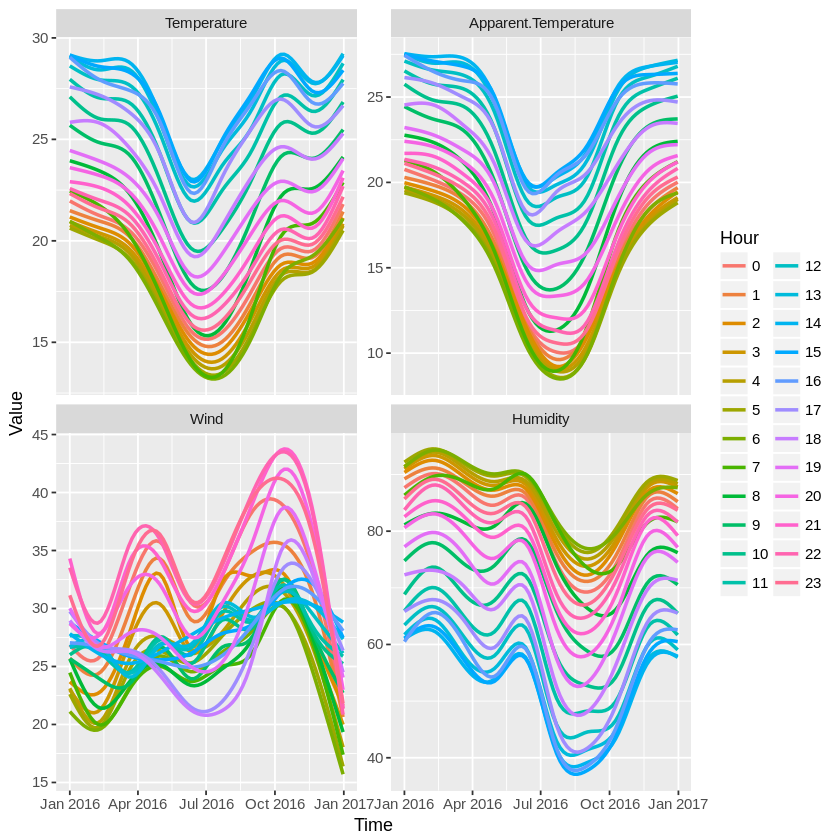

In [18]:
p <- ggplot(data=cepagri.facet, aes(x = Time, y = Value, color = Hour, fill = Hour, group = Hour))
p <- p + facet_wrap(~ Attribute, ncol=2, scales = "free_y")
p <- p + geom_smooth(se = F, method = 'gam', formula = y ~ s(x, bs = "cs"))
p

Apesar de muito bonita, esta visualização é bem mais dificil de ler, uma vez que há muita informação concentrada e sobreposta.

A influência da data e da horá são quase independentes na Temperatura (Real e sensação térmica) e na umidade, e podemos chegar nas mesma conclusões obtidas anteriormente.

Já o vento possui uma iteração mais complicadas: Confirmando as observações anteriores, as épocas de maior ventania ocorrem por volta de Outubro e Maio, e os ventos mais fortes ocorrem sempre por volta das 22h. 

Adicionalmente, neste gráfico é possível perceber que as primeiras horas do dia são de calmaria durante o verão e de ventos moderados no inverno, enquanto que o crespúsculo possui vento moderado no verão e calmaria no inverno. Achei essa inversão muito interessante, e consistente com minha experiência pessoal: Durante o verão sempre preciso fechar as janelas no fim da tarde devido à ventania.